In [20]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy
from scipy import sparse
from scipy.sparse import linalg as spla
from IPython.display import clear_output
import spectral
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

def plot_2D_field(xm, ym, data):
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(111)
   
    cmap_reversed = matplotlib.cm.get_cmap('RdBu_r')
    pcm = ax.pcolormesh(xm, ym, data,cmap=cmap_reversed)
    ax.set_aspect(1)
    fig.colorbar(pcm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.tight_layout()

## 2D IVP

In [21]:

def run(N,LEN):
    y_basis = spectral.Chebyshev(N,[0,LEN])
    x_basis = spectral.Fourier(N,[0,LEN])

    c = spectral.Field([x_basis, y_basis])
    cy = spectral.Field([x_basis, y_basis])
    c_RHS = spectral.Field([x_basis, y_basis])
    cy_RHS = spectral.Field([x_basis, y_basis])
    cyy = spectral.Field([x_basis, y_basis])
    cyy_RHS = spectral.Field([x_basis, y_basis])
    cyyy = spectral.Field([x_basis, y_basis])
    cyyy_RHS = spectral.Field([x_basis, y_basis])
    x = x_basis.grid()[:, None]

    y = y_basis.grid()[None,:]
    y = np.linspace(-LEN,LEN,N, endpoint=True)
    xm, ym = np.meshgrid(x.ravel(), y.ravel())

    alpha = 0.5*(y_basis.interval[-1] - y_basis.interval[0]) 

    dt = 1e-3


    problem = spectral.InitialValueProblem([c, cy,cyy,cyyy], [c_RHS, cy_RHS,cyy_RHS,cyyy_RHS], num_BCs=8)

    diag = (np.arange(N-1)+1)/alpha 
    D = sparse.diags(diag, offsets=1)

    diag0 = np.ones(N)/2
    diag0[0] = 1
    diag2 = -np.ones(N-2)/2
    C = sparse.diags((diag0, diag2), offsets=(0,2))

    Z = sparse.csr_matrix((N, N))

    par = 1 

    for sp in problem.subproblems:
        n = sp.wavenumbers[0]
        
        sp.M = sparse.csr_matrix((8*N+8, 8*N+8))
        sp.M[6*N:7*N, :N] = C
        sp.M[7*N:8*N, N:2*N] = C
        sp.M.eliminate_zeros()
        par = 1.4
        
        L = sparse.bmat([[       D,        Z,   -C,    Z,   Z,  Z,  Z,  Z],
                        [       Z,        D,    Z,   -C,   Z,  Z,  Z,  Z],
                        [       Z,        Z,    D,   Z,   -C,  Z,  Z,  Z],
                        [       Z,        Z,    Z,   D,   Z,  -C,  Z,  Z],
                        [       Z,        Z,    Z,   Z,   D,  Z,  -C,  Z],
                        [       Z,        Z,    Z,   Z,   Z,  D,  Z,  -C],
                        [(-C*2*n**2+C*n**4)-par*C+C,        Z, Z,   Z,(-2*C*n**2)+2*C,Z,D,Z],
                        [       Z, (-C*2*n**2+C*n**4)-par*C+C,    Z,  Z,Z,(-C*2*n**2)+2*C,Z,D]])
        
        
            
        i = np.arange(N)
        BC_rows = np.zeros((8, 8*N))
    
        BC_rows[0, :N] = (-1)**i
        BC_rows[1, :N] = (+1)**i
        BC_rows[2, N:2*N] = (-1)**i
        BC_rows[3, N:2*N] = (+1)**i
        BC_rows[4, 2*N:3*N] = (-1)**i
        BC_rows[5, 2*N:3*N] = (+1)**i
        BC_rows[6, 3*N:4*N] = (-1)**i
        BC_rows[7, 3*N:4*N] = (+1)**i
    
        
        cols = np.zeros((8*N,8))
        cols[  N-1, 0] = 1
        cols[2*N-1, 1] = 1
        cols[3*N-1, 2] = 1
        cols[4*N-1, 3] = 1
        cols[5*N-1, 4] = 1
        cols[6*N-1, 5] = 1
        cols[7*N-1, 6] = 1
        cols[8*N-1, 7] = 1

        
        
        corner = np.zeros((8,8))
        
        sp.L = sparse.bmat([[L, cols],
                            [BC_rows, corner]])
        
        sp.L.eliminate_zeros()



    ts = spectral.SBDF2(problem)
    c.require_grid_space()
    rng = np.random.default_rng(seed=420)
    c.data = np.ones([N,N])
    c.require_grid_space()
    ims = []
    
    #fig = plt.figure(figsize=(10,10))
    cmap_reversed = matplotlib.cm.get_cmap('RdBu_r')
    #ax = fig.subplots(1)

    #pcm = ax.pcolormesh(xm, ym, c.data.T, cmap='RdBu', vmax=1)
    #ax.set_aspect(1)
    #fig.canvas.draw()
    #title = plt.title('t=%f' %ts.time)

    c.require_coeff_space()
    cyyy_RHS.require_coeff_space()

    BCs = np.array([0,0,0,0,0,0,0,0])

    for i in range(1000):
        c.require_coeff_space()
        cyyy_RHS.require_coeff_space()
        c.require_grid_space(scales=2)
        cyyy_RHS.require_grid_space(scales=2)
            
        cyyy_RHS.data = 1*c.data**2-1*c.data**3
        cyyy_RHS.require_coeff_space()
        cyyy_RHS.data = spectral.apply_matrix(C, cyyy_RHS.data, axis=1)

        ts.step(dt, BCs)
        
    c.require_coeff_space()
    return c
        
            


In [22]:
#code used to produce the resolution study 
Ns = [16,32,64,128,256,512]
L=50
error = np.zeros([5,1])
wt = run(Ns[-1],L)
wt.require_grid_space()
j=0
for N in Ns[:-1]:
    w = run(N,L)
    w.require_grid_space(scales=int(Ns[-1]/N))
    error[j,0] = np.max(abs(wt.data-w.data))
    j=j+1




[0, 50]


c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


[0, 50]
[0, 50]
[0, 50]
[0, 50]
[0, 50]


Text(0.5, 1.0, 'Error with solution of resolution N=512')

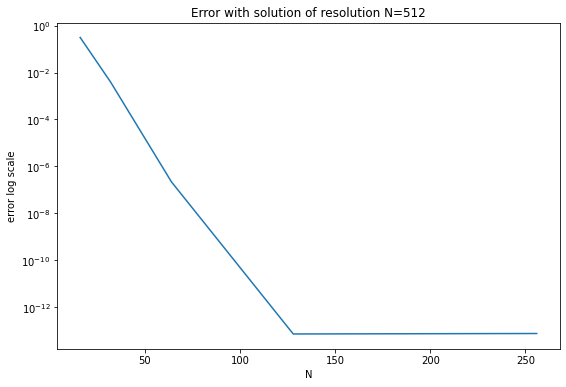

In [17]:
 fig = plt.figure(figsize=(9,6))
plt.plot(Ns[0:-1],error)
plt.yscale('log')

plt.ylabel('error log scale')
plt.xlabel('N')
plt.title('Error with solution of resolution N=512')



In [ ]:
error

array([[6.14112199e-01],
       [5.71762568e-02],
       [1.71459420e-04],
       [5.18572557e-10],
       [1.18793864e-13]])

[-10, 10]


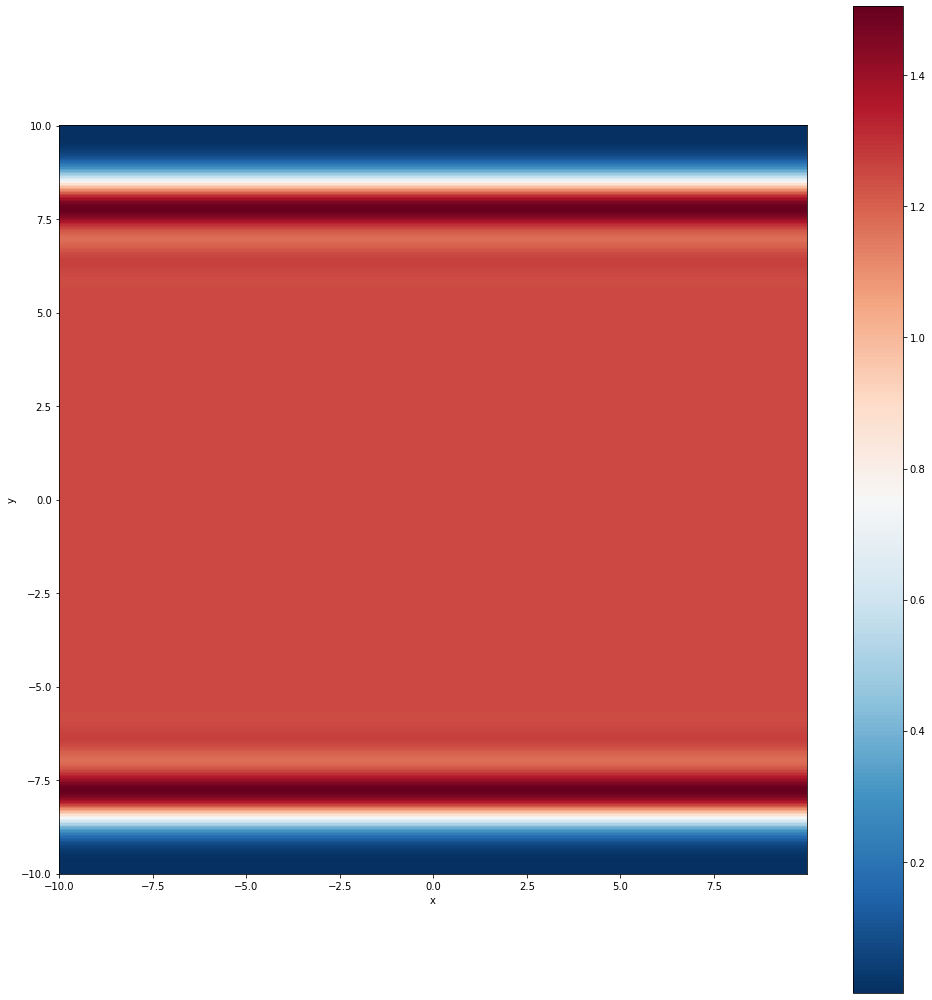

In [ ]:
error
N=512; L=10
y_basis = spectral.Chebyshev(N,[-L,L])
x_basis = spectral.Fourier(N,[-L,L])
x = x_basis.grid()[:, None]
y = y_basis.grid()[None,:]
y = np.linspace(-L,L,N, endpoint=True)
xm, ym = np.meshgrid(x.ravel(), y.ravel())
plot_2D_field(xm,ym,abs(w.data.T))


In [ ]:
N=5
rng = np.random.default_rng(seed=4200)
(2*rng.random((N, N))-1)


array([[ 0.12080054, -0.7356694 , -0.66182313,  0.50531049,  0.2935156 ],
       [ 0.54110506, -0.04607526,  0.99017245,  0.54128262, -0.35019221],
       [-0.28151598, -0.4237538 , -0.87608664,  0.37561728, -0.12029691],
       [ 0.54083444, -0.9270442 ,  0.37732374,  0.71349815, -0.642413  ],
       [ 0.44296403, -0.46353864, -0.13996048,  0.38224722, -0.54329647]])

[0, 50]


c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


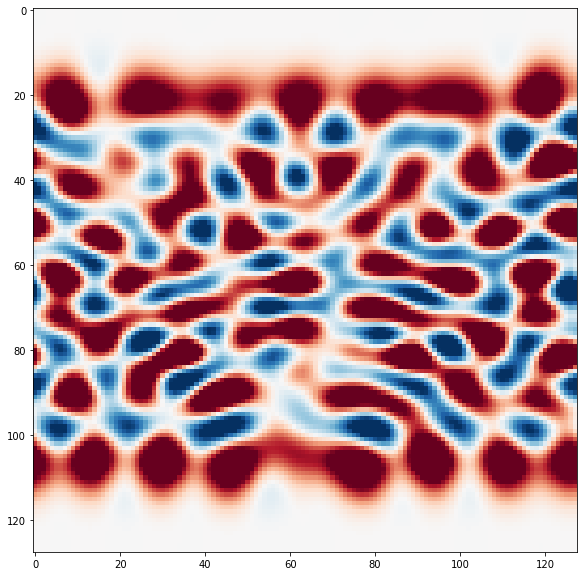

In [19]:
par = 1
N=128 ; L=50
y_basis = spectral.Chebyshev(N,[0,L])
x_basis = spectral.Fourier(N,[0,L])

c = spectral.Field([x_basis, y_basis])
cy = spectral.Field([x_basis, y_basis])
c_RHS = spectral.Field([x_basis, y_basis])
cy_RHS = spectral.Field([x_basis, y_basis])
cyy = spectral.Field([x_basis, y_basis])
cyy_RHS = spectral.Field([x_basis, y_basis])
cyyy = spectral.Field([x_basis, y_basis])
cyyy_RHS = spectral.Field([x_basis, y_basis])
x = x_basis.grid()[:, None]

y = y_basis.grid()[None,:]
y = np.linspace(-L,L,N, endpoint=True)
xm, ym = np.meshgrid(x.ravel(), y.ravel())

alpha = 0.5*(y_basis.interval[-1] - y_basis.interval[0]) 

dt = 1e-3


problem = spectral.InitialValueProblem([c, cy,cyy,cyyy], [c_RHS, cy_RHS,cyy_RHS,cyyy_RHS], num_BCs=8)

diag = (np.arange(N-1)+1)/alpha 
D = sparse.diags(diag, offsets=1)

diag0 = np.ones(N)/2
diag0[0] = 1
diag2 = -np.ones(N-2)/2
C = sparse.diags((diag0, diag2), offsets=(0,2))

Z = sparse.csr_matrix((N, N))



for sp in problem.subproblems:
    n = sp.wavenumbers[0]
    
    sp.M = sparse.csr_matrix((8*N+8, 8*N+8))
    sp.M[6*N:7*N, :N] = C
    sp.M[7*N:8*N, N:2*N] = C
    sp.M.eliminate_zeros()
    
    L = sparse.bmat([[       D,        Z,   -C,    Z,   Z,  Z,  Z,  Z],
                    [       Z,        D,    Z,   -C,   Z,  Z,  Z,  Z],
                    [       Z,        Z,    D,   Z,   -C,  Z,  Z,  Z],
                    [       Z,        Z,    Z,   D,   Z,  -C,  Z,  Z],
                    [       Z,        Z,    Z,   Z,   D,  Z,  -C,  Z],
                    [       Z,        Z,    Z,   Z,   Z,  D,  Z,  -C],
                    [(-C*2*n**2+C*n**4)-par*C+C,        Z, 2*D,   Z,(-2*C*n**2),Z,D,Z],
                    [       Z, (-C*2*n**2+C*n**4)-par*C+C,    2*D,  Z,Z,(-C*2*n**2),Z,D]])
    
    
    
    i = np.arange(N)
    BC_rows = np.zeros((8, 8*N))

    BC_rows[0, :N] = (-1)**i
    BC_rows[1, :N] = (+1)**i
    BC_rows[2, N:2*N] = (-1)**i
    BC_rows[3, N:2*N] = (+1)**i
    BC_rows[4, 2*N:3*N] = (-1)**i
    BC_rows[5, 2*N:3*N] = (+1)**i
    BC_rows[6, 3*N:4*N] = (-1)**i
    BC_rows[7, 3*N:4*N] = (+1)**i

    
    cols = np.zeros((8*N,8))
    cols[  N-1, 0] = 1
    cols[2*N-1, 1] = 1
    cols[3*N-1, 2] = 1
    cols[4*N-1, 3] = 1
    cols[5*N-1, 4] = 1
    cols[6*N-1, 5] = 1
    cols[7*N-1, 6] = 1
    cols[8*N-1, 7] = 1

    
    
    corner = np.zeros((8,8))
    
    sp.L = sparse.bmat([[L, cols],
                        [BC_rows, corner]])
    
    sp.L.eliminate_zeros()



ts = spectral.SBDF2(problem)
c.require_grid_space()
rng = np.random.default_rng(seed=420)
c.data = (rng.random((N, N)))*0.1


c.require_grid_space()
ims = []

fig = plt.figure(figsize=(10,10))
cmap= matplotlib.cm.get_cmap('RdBu_r')

ax = fig.subplots(1)


#pcm = ax.pcolormesh(xm, ym, c.data.T, cmap='RdBu', vmax=1)
#ax.set_aspect(1)
#fig.canvas.draw()
#title = plt.title('t=%f' %ts.time)

c.require_coeff_space()
cyyy_RHS.require_coeff_space()

BCs = np.array([0,0,0,0,0,0,0,0])

for i in range(4000):
    c.require_coeff_space()
    cyyy_RHS.require_coeff_space()
    c.require_grid_space(scales=2)
    cyyy_RHS.require_grid_space(scales=2)
        
    cyyy_RHS.data = 4/5*c.data**2-1*c.data**3
    cyyy_RHS.require_coeff_space()
    cyyy_RHS.data = spectral.apply_matrix(C, cyyy_RHS.data, axis=1)

    ts.step(dt, BCs)
    



    c.require_grid_space()

    #clear_output(wait=True)
    #plot_2D_field(xm,ym,c.data.T)
    #title = plt.title('t=%f' %ts.time)
    #plt.savefig('test'+str(i)+'.png')
    #plt.close()


    
    im = ax.imshow(c.data.T, animated=True,cmap=cmap,vmin=-0.3,vmax=0.3)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False,
                                repeat_delay=1000)
writergif = animation.PillowWriter(fps=30)
ani.save('filename.gif',writer=writergif)


        
   

In [ ]:
c.require_grid_space()
plot_2D_field(xm,ym,abs(c.data.T-w.data.T))

ValueError: operands could not be broadcast together with shapes (256,256) (512,512) 

In [7]:
x_basis.grid()

array([ 0.    ,  1.5625,  3.125 ,  4.6875,  6.25  ,  7.8125,  9.375 ,
       10.9375, 12.5   , 14.0625, 15.625 , 17.1875, 18.75  , 20.3125,
       21.875 , 23.4375])